In [411]:
import sys
import os
sys.path.append("../../../../src/")
#Imports
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
#Custom made imports
import single_particle_sector as sps
from time import time

In [562]:
#Model Parameters
L = 10
J = -1
h = 0
OBC = False

In [564]:
def En(L,J,h,OBC):
    if OBC == True:
        bc = ["OBC","OBC"]
    else:
        bc = ["ABC","PBC"]
    
    ns = []
    Es = []

    for p in range(0,2):
        boundary_condition = bc[p]
        H = sps.H_bdg(h,L,J,boundary_condition)
        E, V = la.eigh(H)
        V = V[:,:L]
        E = E[L:]
        G = sps.G_tfim(V)

        F = G[:L,L:]
        G = G[:L,:L]
        #####
        M = np.eye(L)-2*(G+F)
        n = la.det(M)*(-1)**L * (-1)**p
        Es.append(E)
        ns.append(n)
    return  Es, ns

Es, ns = En(L,J,h,OBC)

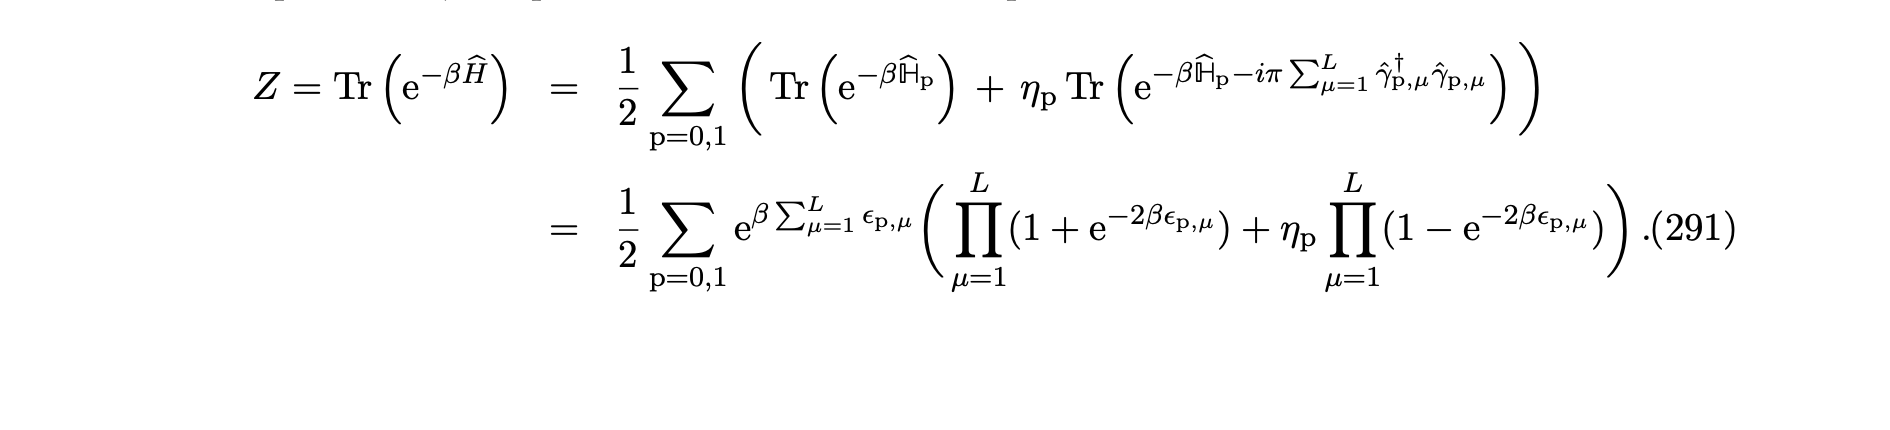

In [547]:
Z_beta = []
T = np.linspace(0.0001,100,1000)
betas = 1/T

def Zi(p,beta):
    E = sum(Es[p])


        
    Z =  (np.prod(1+np.exp(-beta*2*Es[p]))+ns[p]*np.prod(1-np.exp(-2*beta*Es[p])))/2
    #Z = -np.exp(beta*E) * (np.prod(1+np.exp(-beta*2*Es[p]))+ns[p]*np.prod(1-np.exp(-2*beta*Es[p])))/2
    return Z

def Z(beta):
   return Zi(0,beta)+Zi(1,beta)

def F(beta):
    return -np.log(Z(beta))/beta



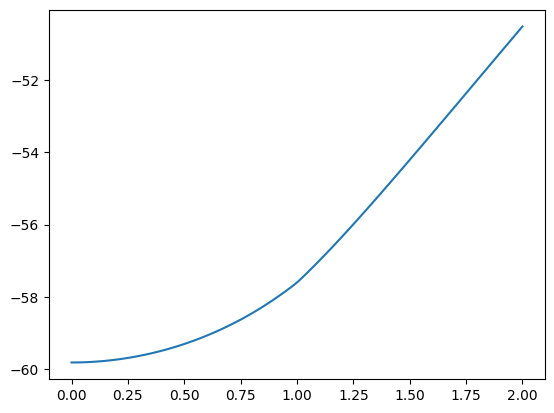

In [548]:
h_i = np.linspace(0,2,100)
beta = 0.1
dat = []
for h in h_i:
    Es, ns = En(L,J,h,OBC)
    dat.append(F(beta))
plt.plot(h_i,dat)

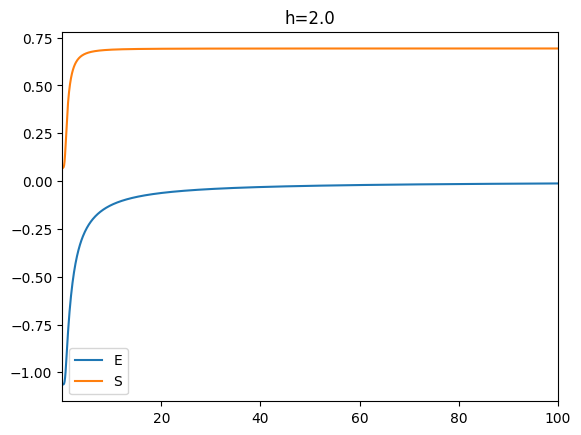

In [549]:
plt.plot(T,E_beta,label="E")
plt.plot(T,S_beta,label="S")
plt.xlim(T[0],T[-1])
plt.title(f"h={h}")
plt.legend()

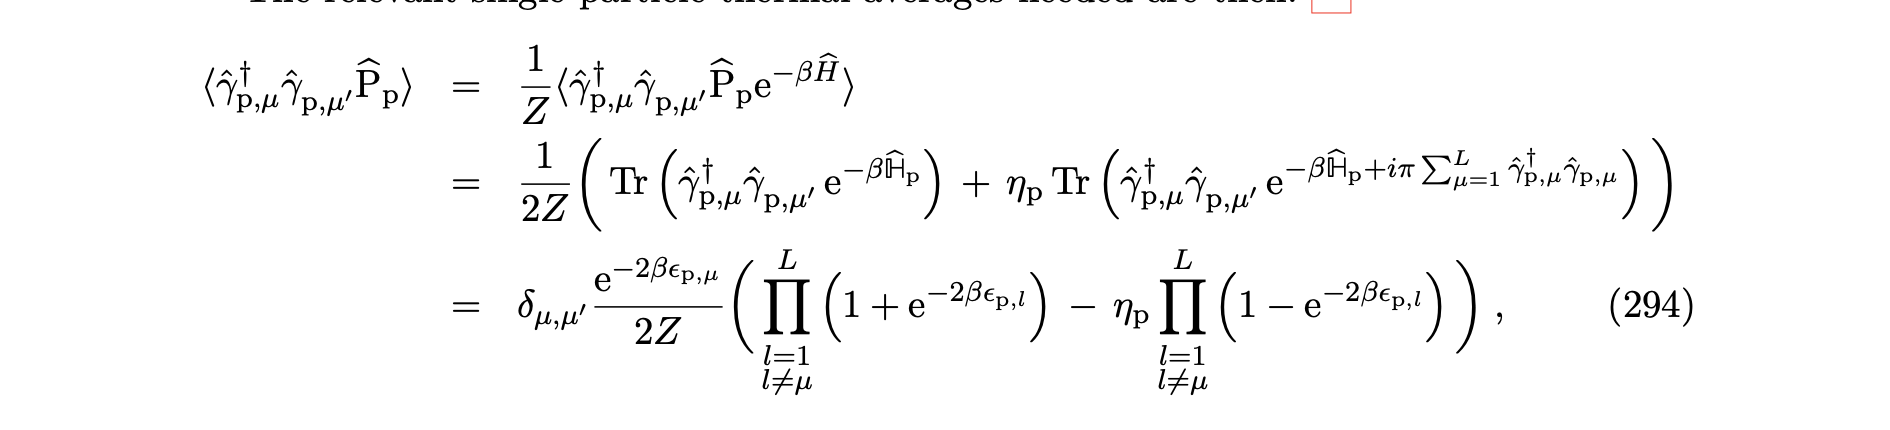

In [565]:
def cap(p,mu,beta):
    pf = np.exp(-2*beta*Es[p][mu])/2/Z(beta)
    E = Es[p].copy()
    E = np.delete(E,mu)
    term1 = np.prod(1+np.exp(-2*beta*E))
    term2 = ns[p]*np.prod(1-np.exp(-2*beta*E))
    return pf*(term1-term2)


def ca(mu,beta):
    return cap(0,mu,beta)+cap(1,mu,beta)

print(ca(0,0))

0.5


In [566]:
def acp(p,mu,beta):
    pf = 1/2/Z(beta)
    E = Es[p].copy()
    E = np.delete(E,mu)
    term1 = np.prod(1+np.exp(-2*beta*E))
    term2 = ns[p]*np.prod(1-np.exp(-2*beta*E))

    return pf*(term1+term2)

def ac(mu,beta):
    return acp(0,mu,beta)+acp(1,mu,beta)


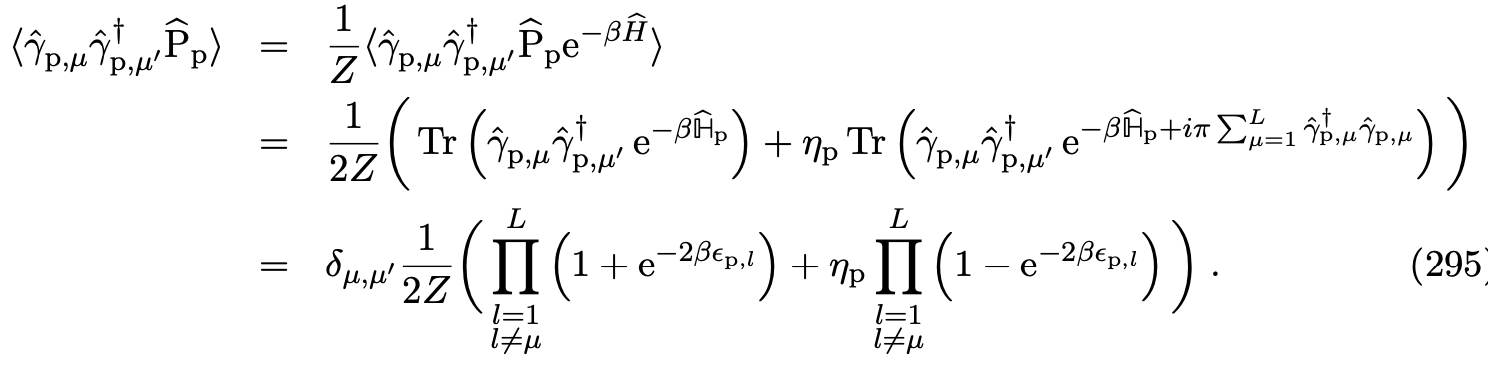

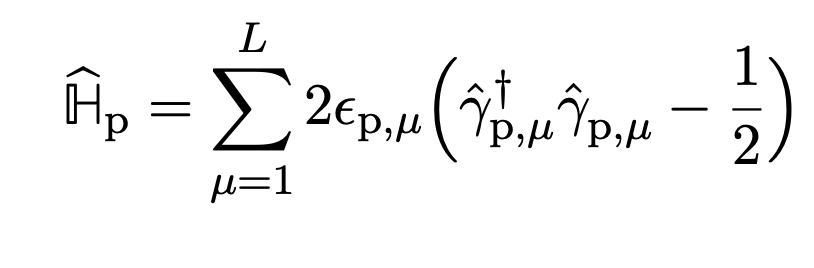

In [587]:

def H_p(p,beta):
    E = Es[p]
    Hp = sum([2*E[mu]*(ca(mu,beta)-1/2) for mu in range(L)])
    return Hp
def H(beta):
    return (H_p(0,beta)+H_p(1,beta))/2

In [596]:
T = np.linspace(0.1,1,100)
beta = 1/T
h = 0.5
L = 100
Es, ns = En(L,J,h,OBC)
E1 = [H(1/ti)/L for ti in T]
Es, ns = En(L,J,h,True)
E2 = [H(1/ti)/L for ti in T]

(0.1, 1.0)

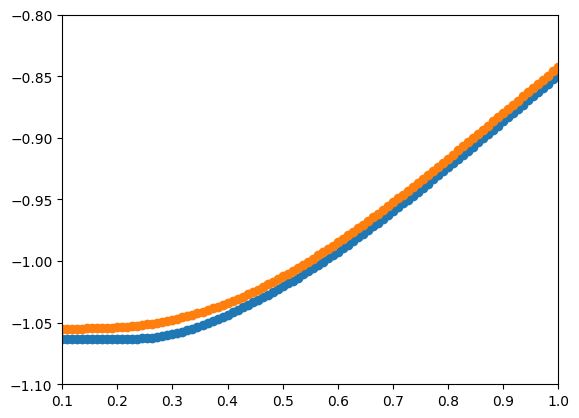

In [602]:
plt.scatter(T,E1)
plt.scatter(T,E2)
plt.ylim(-1.1,-.8)
plt.xlim(T[0],T[-1])


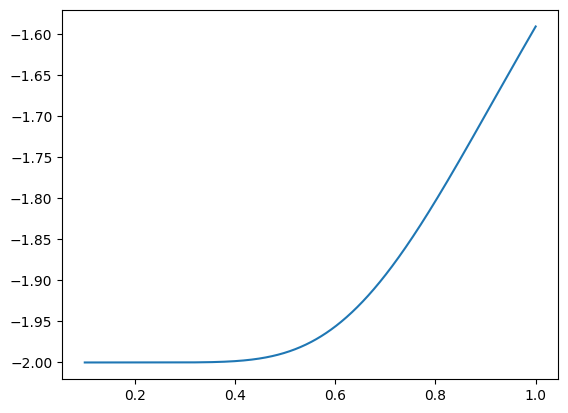